## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Conclusion](#conclusion)

<a id='intro'></a>
### Introduction

Performing an A/B Test for an E-Commerce website to decide whether to implement a new web page design or keep the current design for the same.

<a id='probability'></a>
#### Part I - Probability

In the code block below, we import the required libraries and set the seed for consistency of the results, in case we reuse the code.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We set the seed
random.seed(42)

`1.` In the code block below we read in the `ab_data.csv` data, store it in `df` and view the top few rows.

In [2]:
#read and displat the DataFrame
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
#view the number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
#display the number of unique users
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
#display the proportion of users converted
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
#diplay the total number of mismatches among control and treatment groups, with respect to old and new pages
c_mismatch = df.query("group == 'control' and landing_page != 'old_page'")
t_mismatch = df.query("group == 'treatment' and landing_page != 'new_page'")
total_mismatch = c_mismatch + t_mismatch
total_mismatch.shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
#check for any null values 
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` In the code blocks below, we check for the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. Therefore we create and then merge the DataFrames where **treatment** matches with **new_page** and **control** matches with **old_page**.    

a. We store the new dataframe in **df2**.

In [8]:
# create Dataframe where control matches with old page.
match_c = df.query(" group == 'control' and landing_page == 'old_page'")

In [9]:
# create Dataframe where treatment matches with new page.
match_t = df.query("group == 'treatment' and landing_page == 'new_page'")

In [10]:
# merge both DataFrames and store the new DataFrame in df2.
df2 = match_t.merge(match_c, how='outer')

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer the following questions.

a. How many unique **user_id**s are in **df2**?

In [12]:
# check for unique user_ids
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
# check for repeated user_id
df2[df2['user_id'].duplicated()]['user_id']

1404    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
# extract and view the information for the repeated user_id
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
# remove the duplicate row
df2.drop(1404, inplace=True)

`4.` Use **df2** in the cells below to answer the following questions.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
# calculate the probability of converting a user regardless of the page
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
# calculate the probability of converting a user from the control group
prob_ct = df2[df2['group'] == 'control']['converted'].mean()
prob_ct

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
# calculate the probability of converting a user from the treatment group
prob_tr = df2[df2['group'] == 'treatment']['converted'].mean()
prob_tr

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
# calculate the probability of a user receiving a new page
prob_new_page = (df2['landing_page'] == 'new_page').mean()
prob_new_page

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer:** Depending on the metric we focus on, our assumption is bound to change. In conclusion we cannot confidently say that the new treatment page leads to more conversions as both pages have almost similar proportions.

<a id='ab_test'></a>
### Part II - A/B Test

`1.` If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, our null and alternative hypotheses will be:  

**Hypothesis.** $H_0$ : **$p_{old}$** $\geq$ **$p_{new}$**
                          $H_1$ : **$p_{new}$** > **$p_{old}$** 

Where **$p_{old}$** and **$p_{new}$**, are the converted rates for the old and new pages.

`2.`In the following code blocks we assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

We use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

We perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

In the cells below we provide the necessary parts of this simulation as we answer the following questions.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
# calculate the conversion rate for P_new
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
# calculate the conversion rate for P_old 
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
# calculate the number of users in treatment group
n_new = df2.query("group == 'treatment'").shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
#calculate the number of users in control group
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
#simulate conversion rate for new page
new_page_converted = np.random.choice([0,1], size=n_new, p=(p_new,1-p_new))

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
#simulate conversion rate for old page
old_page_converted = np.random.choice([0,1], size=n_old, p=(p_old,1-p_old))

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
# calculate the difference in conversion rate
new_page_converted.mean() - old_page_converted.mean()

-0.00094780174278907836

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
# run 10000 iterations of the same simulation
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new, p=(p_new,1-p_new))
    old_page_converted = np.random.choice([0,1], size=n_old, p=(p_old,1-p_old))
    p_diffs.append( new_page_converted.mean() - old_page_converted.mean())

In [28]:
# convert p_diff into a numpy array 
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.

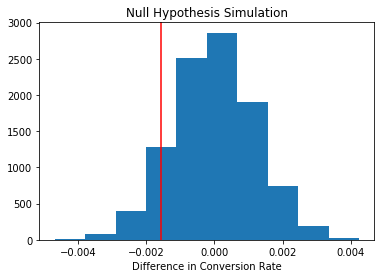

In [29]:
# plot a histogram of distribution obtained via simulation
plt.hist(p_diffs)
plt.title('Null Hypothesis Simulation')
plt.xlabel('Difference in Conversion Rate')
plt.axvline(prob_tr - prob_ct, color='Red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
obs_diff = prob_tr - prob_ct
(p_diffs > obs_diff).mean()

0.90590000000000004

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:** This value is called the 'p-value'. It is the probability of finding our statistic given that the null hypothesis is true. Our p-value came out to be 0.9059, comparing it with the Type-I error or 0.05 or 5% we can conclude that we fail to reject the null, therefore there is not much difference between the new and old pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
# use a built-in simulation
import statsmodels.api as sm

convert_old = df2.query("group == 'control' and converted == 1")['converted'].count()
convert_new = df2.query("group == 'treatment' and converted == 1")['converted'].count()
n_old = df2.query("group == 'control'").shape[0]
n_new = df2.query("group == 'treatment'").shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [33]:
# calculate z-test
sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old], alternative='larger')

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer.** The p-value obtained is 0.9050 which is still very large compared to Type-I error rate of 0.05 and a z-score of 1.31 which is also smaller compared to a required critical z-score of ~ 1.96, hence there is no evidence for rejecting the null hypothesis. In conclusion the conversion rate of the new pages is not greater than the conversion rate of old pages.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:** Logistic Regression, as we are dealing with only two possible outcomes.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
# create a dummy variable and add an intercept.
df2[['ab_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [38]:
# instantiate and fit the regression model
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
# import scipy and view the result summary
from scipy import stats
stats.chisqprob = lambda chisq, df:stats.chi2.sf(chisq, df)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 12 Aug 2020   Pseudo R-squ.:               8.077e-06
Time:                        02:09:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer.** The p-value associated with ab_page is 0.190. Which is again larger than our type-I error rate, thus, we fail to reject the null. This value differs from the value we found in Part II because of different sets of null and alternative hypothesis in Part II and Part III. 
As in Part II we chose the null to have a conversion rate which is greater than or equal to the conversion rate of the alternative. <br>

Whereas in Part III we chose the null where difference between conversion of new and old pages is zero and alternative as difference between conversion of new and old pages either greater than or less than zero.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:** Since all prior approches have shown same results, now we will consider adding other factors into our regression model.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [42]:
# read in a new DataFrame having user's countries
countries_df = pd.read_csv('countries.csv')
#create a new DataFrame by joining df2 and countries_df
df_n = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
# view a few rows of the new DataFrame
df_n.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [43]:
# check user countries
df_n['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [44]:
# create dummy variables
df_n[['CA','UK','US']] = pd.get_dummies(df_n['country'])
df_n.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [46]:
#instantiate and fit the regression model
log_mod = sm.Logit(df_n['converted'], df_n[['intercept','US','UK']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 12 Aug 2020   Pseudo R-squ.:               1.521e-05
Time:                        02:20:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

**Result:** With Canada as the baseline country we are able to see that the correlation coefficient for US and UK is very small, therefore with can see that the relationship between country and conversion is weak.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
# check for interaction between page and country
df_n['US_page'] = df_n['US'] * df_n['ab_page']
df_n['UK_page'] = df_n['UK'] * df_n['ab_page']
df_n.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US,US_page,UK_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1


In [48]:
# instantiate and fit the model
log_mod = sm.Logit(df_n['converted'], df_n[['intercept', 'ab_page', 'US', 'UK', 'US_page', 'UK_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 12 Aug 2020   Pseudo R-squ.:               3.482e-05
Time:                        02:25:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US_page        0.0469      0.054      0.872      0.383      -0.059       0.152
UK_page        0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

**Result:** 
In both summaries we see above the p-values are either comparatively larger than our Type-I error rate or insignificant based on this fact we can say that the interaction between countries and pages does not amount to much and we fail to reject the null.

<a id='conclusions'></a>
## Part IV - Conclusion

Throughout our experiment p-values are comparatively larger than our Type-I error rate. It is therefore in the website's best interest to stick to the old page design based on the data we have as the results of this A/B Test do not provide any evidence that the new page designs have a higher conversion rate than the old page designs.


In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0